In [1]:
import gzip
import os
import pysam

from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
sns.set_style('white')
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from collections import Counter
from functools import reduce
from operator import add


from scipy.stats import hypergeom
statf = hypergeom.sf
from math import log

from scipy.stats import pearsonr
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.metrics.pairwise import pairwise_distances as PWD


import warnings
warnings.filterwarnings('ignore')

## Preprocessing:

In [6]:
# Here we load the mapping of genes to modules from csv
# into dictionaries:
dan_cl = pd.read_csv("./data/wgcna_results/wgcna_dre_modulekey.tab.gz", sep='\t')
dan_cl.columns = ['geneID','clusterID','updown']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv("./data/wgcna_results/wgcna_bla_modulekey.tab.gz", sep='\t')
bla_cl.columns = ['geneID','clusterID','updown']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

# bla_cl_d ~= {'BL06687': 'greenyellow',
#  'BL12105': 'greenyellow',
#  'BL18033': 'magenta',....}

## We now want to map PWMs to modules

To do this, we will use the BASAL region of genes:

In [7]:
# gene to "gene region" connection
# This dataframe connects each gene to a genomic region:
dan_greg = pd.read_csv("./data/genomic_regions/BASAL_dre.bed", sep='\t', header=None)
dan_greg.columns = ['chrom','start','end','geneID','strand']
dan_greg['score'] = 0
dan_greg = dan_greg[['chrom','start','end','geneID','score','strand']]

bla_greg = pd.read_csv("./data/genomic_regions/BASAL_bla.bed", sep='\t', header=None)
bla_greg.columns = ['chrom','start','end','geneID','strand']
bla_greg['score'] = 0
bla_greg = bla_greg[['chrom','start','end','geneID','score','strand']]

and of course the PWMs that have been mapped on ATACseq peaks already:

In [8]:
# load the PWM hits in a pybedtools object and sort
dan_motif_bed = BT("./data/danre_pwm_hits.bed.gz").sort()
bla_motif_bed = BT("./data/bralan_pwm_hits.bed.gz").sort()

amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

We also need the following table, which assigns a unique id number to each PWM.

In [9]:
# busy-work to assign unique IDs to each PWM family
superfams = pd.read_csv("./data/PWMname_to_ProteinFamily.tsv", sep='\t', header=None)
def order_things(x):
    return ';'.join(sorted(x.split(';')))
lot = []
for i,row in superfams.iterrows():
    if ';' not in row[1]:
        lot.append( row.tolist() )
    else:
        a,b = [';'.join(jj) for jj in zip(*sorted(zip(row[1].split(';'), row[2].split(';')), key= lambda x: int(x[0]) ))]
        lot.append( [row[0], a, b] )
superfams_ = pd.DataFrame(lot)
SFD = dict(superfams_[[0,1]].to_records(index=False))

fuid = {}
c = 0
for v in SFD.values():
    if v not in fuid:
        fuid[v] = c
        c += 1
SFDu = {k:fuid[v] for k,v in SFD.items()}

superfams_['u'] = superfams_[0].map(SFDu)
SF = superfams_.set_index('u')

We will now compute the LOJ intersection of the PMs to the BASAL regions,
For each gene this will give us all PWMs in its "regulatory landscape"

In [10]:
# Map the cluster ID to gene IDs:
dan_greg['cluster'] = dan_greg.geneID.map(dan_cl_d)
dan_greg = dan_greg[~dan_greg.cluster.isnull()]

bla_greg['cluster'] = bla_greg.geneID.map(bla_cl_d)
bla_greg = bla_greg[~bla_greg.cluster.isnull()]

# cast the gene region dataframes into pybedtools objects
# and intersect with motifs (with LEFT OUTER JOIN)
dan_loj = (BT()
        .from_dataframe(dan_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(dan_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

dan_loj = dan_loj[dan_loj.blockCount != '.']
dan_loj['fam'] = dan_loj.blockCount.map(SFDu)
dan_loj = dan_loj[~dan_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)

bla_loj = (BT()
        .from_dataframe(bla_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(bla_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

bla_loj = bla_loj[bla_loj.blockCount != '.']
bla_loj['fam'] = bla_loj.blockCount.map(SFDu)
bla_loj = bla_loj[~bla_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)
bla_loj.head()

# we had 
# gene_module --> genes
# genes --> genomic_regions
# motifs --> genomic_positions

# and we managed to connect them:
# module/cluster --> genes -> genomic regions --> motifs

,chrom,start,end,name,score,strand,blockCount,fam
1,Sc0000000,20509,26510,blue,0,+,C2H2_ZF_Average_244,11.0
5,Sc0000000,20509,26510,blue,0,+,ARID_BRIGHT_RFX_M4343_1.02,3.0
6,Sc0000000,20509,26510,blue,0,+,RFX_Average_38,3.0
7,Sc0000000,20509,26510,blue,0,+,bZIP_Average_125,236.0
8,Sc0000000,20509,26510,blue,0,+,C2H2_ZF_M6539_1.02,21.0


In [11]:
# convert the left outer join dataframes into
# tables that contain a count per TF per stage:
bla_loC = [Counter(g.fam) for gn,g in bla_loj.groupby("name")]
bla_temp = pd.DataFrame(bla_loC)   
bla_temp = bla_temp.fillna(0)   
clustorder = [transA[gn] for gn,g in bla_loj.groupby("name")]

bla_temp.index = clustorder
bla_table = bla_temp.copy()

dan_loC = [Counter(g.fam) for gn,g in dan_loj.groupby("name")]
dan_temp = pd.DataFrame(dan_loC)   
dan_temp = dan_temp.fillna(0)   
clustorder = [transZ[gn] for gn,g in dan_loj.groupby("name")]

dan_temp.index = clustorder
dan_table = dan_temp.copy()
dan_table.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
larvae 7d melanin,223,537,14.0,71,21,114,18,13.0,69,6,...,14,24,15,11,10,53,10,50,53,52
Ovary/ Sperm,368,2109,52.0,239,66,204,39,29.0,182,33,...,59,53,67,48,38,148,30,103,116,162
Brain,1714,5518,129.0,953,241,1183,185,101.0,549,70,...,122,218,215,140,132,457,89,371,304,503
Cilium,531,3008,61.0,786,103,334,63,57.0,241,30,...,69,86,105,82,71,166,57,145,176,223
Liver(carboxi.met./ lipid trans),29,107,0.0,5,10,28,2,0.0,6,2,...,4,6,4,3,2,7,3,9,6,3


There might be some differences in the columns of the two tables, lets fix that:

In [12]:
# Get a list of the TFs that are found in both species:
dan_allfams = set(dan_table.columns)
bla_allfams = set(bla_table.columns)
allfams = sorted([ int(x) for x in dan_allfams.intersection(bla_allfams)])

In [13]:
len(dan_allfams), len(bla_allfams),len(allfams)

(243, 242, 242)

## Normalization/Scaling

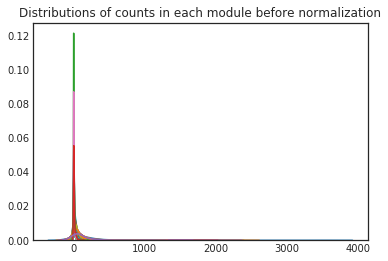

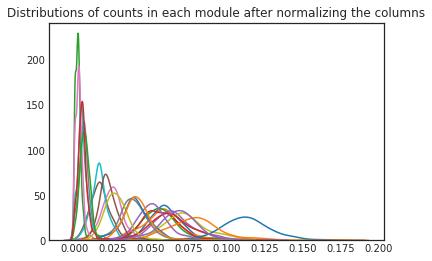

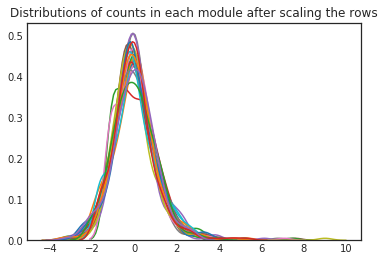

In [14]:
plt.figure()
for rowi,row in bla_table.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module before normalization')
plt.show()

# We divide each count with the sum for each TF,
# to normalize for TF promiscuity
bla_toplot = (bla_table.loc[:,allfams]/bla_table.loc[:,allfams].sum())

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module after normalizing the columns')
plt.show()

# then scale the rows to normalize for module size
bla_toplot.loc[:,:] = scale(bla_toplot, axis=1)

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module after scaling the rows')
plt.show()

dan_toplot =  (dan_table.loc[:,allfams]/dan_table.loc[:,allfams].sum())
dan_toplot.loc[:,:] = scale(dan_toplot, axis=1)      

We can now directly compare modules between the two species.     
We compute pairwise correlations next:

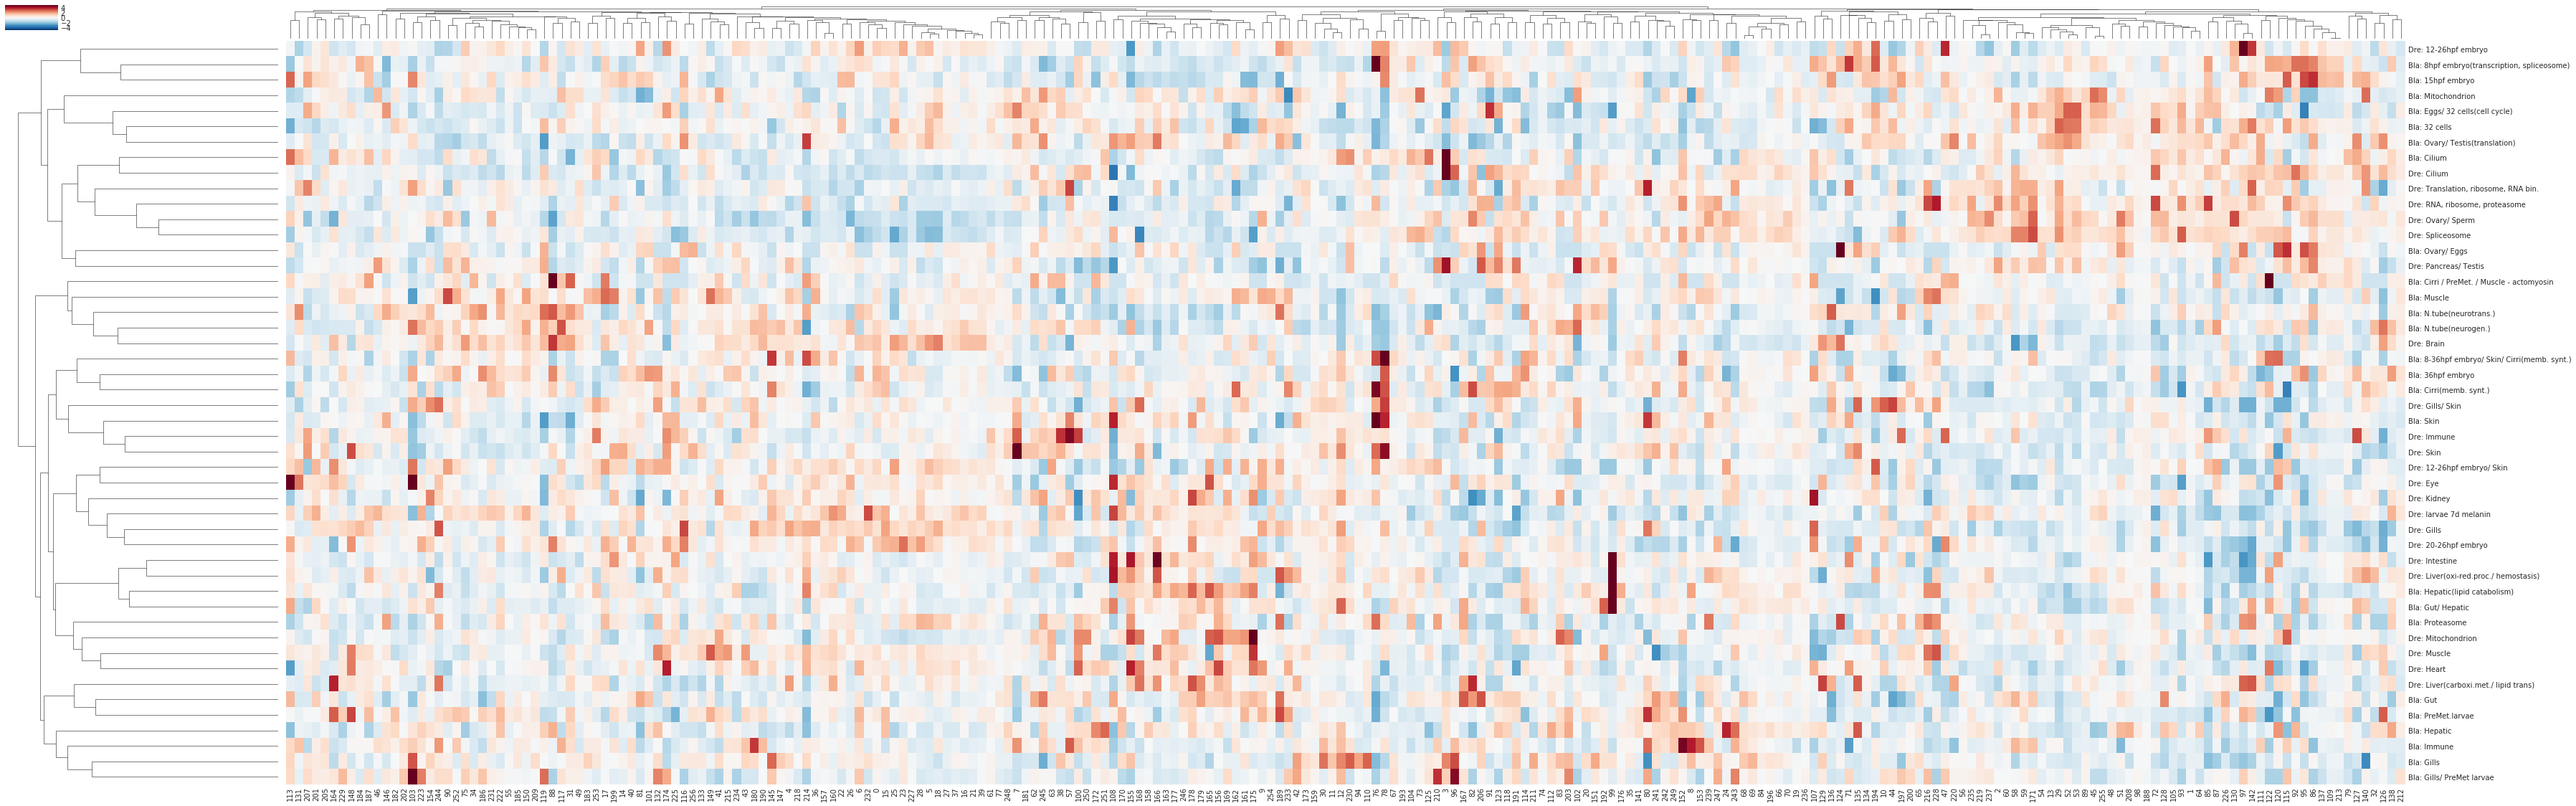

In [17]:
cbtp = bla_toplot.copy()
cbtp.index = ["Bla: "+x for x in  bla_toplot.index.values]
cdtp = dan_toplot.copy()
cdtp.index = ["Dre: "+x for x in  dan_toplot.index.values]
plt.rcParams['svg.fonttype'] = 'none'
# we can now merge the dataframes of the two species and try to cluster them together:

rawcg = sns.clustermap(pd.concat([cbtp,cdtp]),
                       metric='correlation',
                       method='average',
                        figsize=(60,20),
                      linewidths=0,
                      vmin=-5, vmax=5,
                       xticklabels=True,
                      cmap='RdBu_r')
                   
_ = plt.setp(rawcg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [15]:
transA = {
'black' : '32 cells',
'blue' : 'N.tube(neurotrans.)',
'brown' : 'Gills',
'cyan' : 'N.tube(neurogen.)',
'darkmagenta' : 'Ovary/ Testis(translation)',
'darkorange' : 'Cilium',
'darkred' : 'Muscle',
'darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)',
'darkslateblue' : '8hpf embryo(transcription, spliceosome)',
'darkturquoise' : '36hpf embryo',
'green' : 'Eggs/ 32 cells(cell cycle)',
'greenyellow' : 'Hepatic(lipid catabolism)',
'lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin',
'lightpink4' : '15hpf embryo',
'magenta' : 'Skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'Ovary/ Eggs',
'pink' : 'Gut',
'plum1' : 'Gut/ Hepatic',
'plum2' : 'Proteasome',
'red' : 'PreMet.larvae',
'salmon' : 'Cirri(memb. synt.)',
'sienna3' : 'Hepatic',
'thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {
 'bisque4' : "larvae 7d melanin",
'black' : "Ovary/ Sperm",
'blue' : "Brain",
'brown' : "Cilium",
'brown4' : "Liver(carboxi.met./ lipid trans)",
'coral2' : "Mitochondrion",
'darkgreen' : "Intestine",
'darkgrey' : "RNA, ribosome, proteasome",
'darkmagenta' : "Translation, ribosome, RNA bin.",
'darkorange' : "Muscle",
'darkred' : "Liver(oxi-red.proc./ hemostasis)",
'darkseagreen4' : "12-26hpf embryo/ Skin",
'darkslateblue' : "Immune",
'green' : "Spliceosome",
'honeydew1' : "12-26hpf embryo",
'ivory' : "Eye",
'lightcyan' : "Heart",
'lightgreen' : "Pancreas/ Testis",
'magenta' : "Gills",
'pink' : "Skin",
    
'salmon' : "20-26hpf embryo",
'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

transA_sh = {
'black' : 'a-32cells',
'blue' : 'a-n.tube-syna',
'brown' : 'a-gills',
'cyan' : 'a-n.tube-neuro',
'darkmagenta' : 'a-ov.tes.-transl',
'darkorange' : 'a-cilium',
'darkred' : 'a-muscle',
'darkseagreen4' : 'a-emb.8-36',
'darkslateblue' : 'a-embr.8-spli.',
'darkturquoise' : 'a-embryo 36',
'green' : 'a-egg-32cells',
'greenyellow' : 'a-hepa.-lipid',
'lavenderblush3' : 'a-actomyos',
'lightpink4' : 'a-embr.15',
'magenta' : 'a-skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'a-ovary-egg',
'pink' : 'a-gut',
'plum1' : 'a-gut-hepa.',
'plum2' : 'a-proteasome',
'red' : 'a-pm larvae',
'salmon' : 'a-cirri (memb.)',
'sienna3' : 'a-hepatic',
'thistle2' : 'a-gills-pm larv.',
'turquoise' : 'Mitochondrion'}
transZ_sh = {
 'bisque4' : "z-larv7d-mel",
'black' : "z-ovary-sperm",
'blue' : "z-brain",
'brown' : "z-cilium",
'brown4' : "z-liver b",
'coral2' : "Mitochondrion",
'darkgreen' : "z-intestine",
'darkgrey' : "z-ribo.-proteas",
'darkmagenta' : "z-translation",
'darkorange' : "z-muscle",
'darkred' : "z-liver a",
'darkseagreen4' : "z-embr.12-26",
'darkslateblue' : "Immune",
'green' : "z-splicing",
'honeydew1' : "z-emb12-26-skn",
'ivory' : "z-eye",
'lightcyan' : "z-heart",
'lightgreen' : "z-panc.-testis",
'magenta' : "z-gills",
'pink' : "z-skin",
'salmon' : "z-emb.20-26",
'yellow4' : "z-kidney",
'yellowgreen' : "z-gills early"}